# FPE - Breathing trap

In this notebook, we look at another example of a time-dependent potential energy landscape that is slightly more complex than the translating harmonic trap. In this situation, we investigate the dynamics of a diffusing system in the presence of a *breathing* harmonic potential. More succinctly, we investigate a system subjected to the potential energy function

$$ E(x, t) = \frac{k(t)}{2}x^2 $$

In this case, the trap strength is time-dependent, and changes between an initial value $k_0$ at time $t=0$ and $k_{\tau}$ at time $t=\tau$.  So, here the effective Fokker-Planck equation governing the system dynamics is

$$ \partial_t p(x, t) = -\beta Dk(t) \partial_x [x p(x, t)] + D\partial_x^2 p(x, t) $$

In this notebook, we will look at the simulation of this evolution, introducing an explicit time-dependence into the potential (as well as how to implement that in practice) as well as measuring the path-dependence of the work required (as well as the variance of the work) and its dependence on the spacific path. Towards this end, we effectively will confirm the related research finding of Sivak and Crooks in Ref.[1] expressing the optimal minimum-dissipation control protocol ($\dot{k}(t)$) for this system within the linear-response regime.

#### References
- [1] D.A. Sivak & G.E. Crooks, "Thermodynamic metrics and optimal paths", *Phys. Rev. Lett.*, **2012**
- [2] S.J. Large & D.A. Sivak, "Discrete Optimal Control: Minimizing Dissipation in Discretely Driven Nonequilibrium Systems", *J. Stat. Mech.*, **2019**
- [3] D.A. Sivak & G.E. Crooks, "Near-equilibrium measurements of nonequilibrium free energy", *Phys. Rev. Lett.*, **2012**

In [1]:
# First import the relevant modules
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Iterable, Optional
from pathlib import Path
sns.set(style="darkgrid", palette="hls")

from FPE.Integrator import FPE_Integrator_1D
import FPE.forceFunctions as ff

# Dynamics parameters
D = 1.0
dt = 0.0005
dx = 0.05
x_array = np.arange(-2.5, 2.5, dx)

# and start, initialize an integrator object
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="hard-wall", output=False)



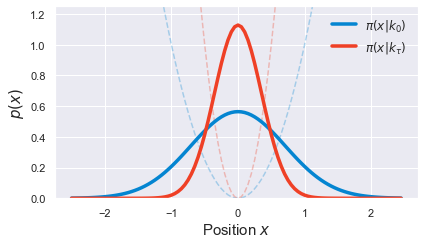

In [3]:
# Initialize the system in its equilibrium distribution
k_init = 2.0
k_final = 8.0
init_var = 1 / k_init
final_var = 1/  k_final

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(fpe.xArray, 0.5 * k_init * (fpe.xArray ** 2), '--', color=sns.xkcd_rgb["cerulean"], alpha=0.3)
ax.plot(fpe.xArray, 0.5 * k_final * (fpe.xArray ** 2), '--', color=sns.xkcd_rgb["tomato"], alpha=0.3)

fpe.initializeProbability(0, init_var)
ax.plot(fpe.xArray, fpe.prob.copy(), linewidth=3.5, color=sns.xkcd_rgb['cerulean'], label=r"$\pi(x|k_0)$")

fpe.initializeProbability(0, final_var)
ax.plot(fpe.xArray, fpe.prob.copy(), linewidth=3.5, color=sns.xkcd_rgb["tomato"], label=r"$\pi(x|k_{\tau})$")

ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$p(x)$", fontsize=15)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(0, 1.25)
plt.tight_layout()


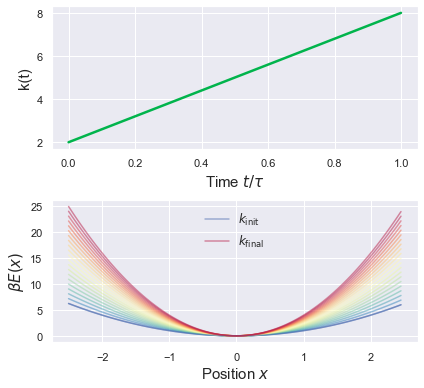

In [4]:
# Now, we can simulate this by looping over a time index, updating the trap
# stiffness paraneter in time

# For a constant control-parameter velocity protocol over a predetermined time
def build_naive_protocol(
    k_init: float, k_final: float, tau: float, dt: float
) -> np.ndarray:
    n_steps = int(tau / dt)
    k_protocol = np.linspace(k_init, k_final, n_steps)
    return k_protocol

fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
tau = 1
protocol_time = np.arange(0, tau, dt)
protocol = build_naive_protocol(2, 8, tau, dt)
Pal = sns.color_palette("Spectral_r", len(protocol) // 100)

ax[0].plot(protocol_time, protocol, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])

for i, k in enumerate(protocol):
    if i % 100 == 0:
        ax[1].plot(x_array, 0.5 * k * (x_array ** 2), color=Pal[i//100], alpha=0.5)

ax[1].plot(x_array, 0.5 * protocol[0] * (x_array ** 2), color=Pal[0], alpha=0.5, label=r"$k_{\rm init}$")
ax[1].plot(x_array, 0.5 * protocol[-1] * (x_array ** 2), color=Pal[-1], alpha=0.5, label=r"$k_{\rm final}$")

ax[1].legend(fontsize=12, frameon=False)
ax[0].set_xlabel(r"Time $t / \tau$", fontsize=15)
ax[0].set_ylabel(r"k(t)", fontsize=15)

ax[1].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_ylabel(r"$\beta E(x)$", fontsize=15)
plt.tight_layout()

In [5]:
# To simulate the distribution under this protocol, we can just loop over these values
fpe.initializeProbability(0, 1 / k_init)
fpe.initializePhysicalTrackers()
prob_tracker = []
time_tracker = []
work_tracker = []

dk = protocol[1] - protocol[0]

for i, k in enumerate(protocol):
    if i%10 == 0:
        prob_tracker.append(fpe.prob)    
        time_tracker.append(protocol_time[i])
    fpe.work_step(([k, 0]), ([k + dk, 0]), ff.harmonicForce, ff.harmonicEnergy)


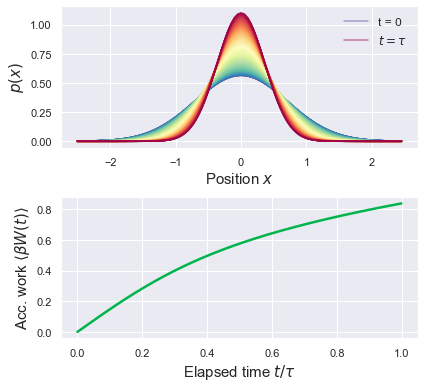

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
Pal = sns.color_palette("Spectral_r", len(prob_tracker))

ax[0].plot(x_array, prob_tracker[0], color=Pal[0], alpha=0.5, label=r"t = 0")
for i, prob in enumerate(prob_tracker):
    ax[0].plot(x_array, prob, color=Pal[i], alpha=0.5)
ax[0].plot(x_array, prob_tracker[-1], color=Pal[-1], alpha=0.5, label=r"$t = \tau$")
ax[0].legend(fontsize=12, frameon=False)

ax[1].plot(protocol_time, fpe.workTracker, color=sns.xkcd_rgb["shamrock"], linewidth=2.5)

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$p(x)$", fontsize=15)
ax[1].set_xlabel(r"Elapsed time $t / \tau$", fontsize=15)
ax[1].set_ylabel(r"Acc. work $\langle\beta W(t)\rangle$", fontsize=15)

plt.tight_layout()


In [7]:
# We can then look at the total trajectory of accumulated work as a function of
# diffusion coefficient: lower D -> slower relaxation -> higher work done

D_arr = [0.125, 0.25, 0.5, 1, 2]
fpe_arr = [FPE_Integrator_1D(diff, dt, dx, x_array, boundaryCond='hard-wall', output=False) for diff in D_arr]
dk = protocol[1] - protocol[0]

# Now run the same protocol over each diffusion coefficient
res_dict = {}
for diff, fpe in zip(D_arr, fpe_arr):
    res_dict[f"D = {diff}"] = {}
    fpe.initializeProbability(0, 1 / k_init)
    fpe.initializePhysicalTrackers()
    prob_tracker = []
    time_tracker = []
    cp_tracker = []
    for i, k in enumerate(protocol):
        if i % 10 == 0:
            prob_tracker.append(fpe.prob)
            time_tracker.append(protocol_time[i])
            cp_tracker.append(k)
        fpe.work_step(([k, 0]), ([k + dk, 0]), ff.harmonicForce, ff.harmonicEnergy)
        
    res_dict[f"D = {diff}"]["prob"] = prob_tracker.copy()
    res_dict[f"D = {diff}"]["time"] = time_tracker.copy()
    res_dict[f"D = {diff}"]["work"] = fpe.workTracker.copy()
    res_dict[f"D = {diff}"]["CP_val"] = cp_tracker.copy()



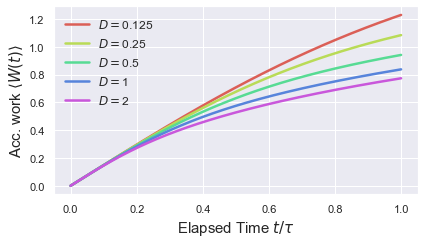

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

Pal = sns.color_palette("hls", len(fpe_arr))

for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)    
plt.tight_layout()

Furthermore, in a timescale-separated limit, when the system does not respond at all to the changes to the potential, this is effectively (from the standpoint of work done) a scenario where the control variable is discretely changing (*i.e.* the initial distribution will not respond to the changing control protocol). If we assume that the accumulation of work will be linear (which is true because the protocol is naive and the forces are linear) then the path of accumulated work will be linear, with final value given by the relative entropy between the two distributions, as was shown in Ref.[4],

$$ \langle \beta W \rangle_{\infty} = D_{\rm KL}\left(p_i || p_f\right) = \int p_i(x) \ln\frac{p_i(x)}{p_f(x)}{\rm d}x $$

While the relative entropy provides an deeper and general understanding of the quantity, in this case we can just calcualte the integral expression directly. Here, the probability distribution is effectively frozen, and so the average work done in this limit corresponds to the integral

$$ \langle \beta W \rangle_{\infty} = \beta\int \left( E_{\rm f}(x) - E_{\rm i}(x)\right) \pi_{\rm i}(x) {\rm d}x $$
$$ = \frac{1}{2}(k_{\rm f} - k_{\rm i})\int x^2 \pi_{\rm i}(x){\rm d}x$$
$$ = \frac{(k_{\rm f} - k_{\rm i})}{2 k_{\rm i}} $$

thus, in our case where $k_{\rm i} = 2$ and $k_{\rm f} = 8$ the result simplifies to

$$ \langle \beta W \rangle_{\infty} = \frac{3}{2} $$


In [9]:

# First we can calculate this numerically, as we would like to be able to do so
# andyways in waht follows
def get_rel_ent(p1: np.ndarray, p2: np.ndarray, dx: float) -> float:
    integrand = p1 * np.log( p1 / p2 )
    return np.sum(integrand * dx)

p1 = np.exp(-0.5 * k_init * x_array)
p2 = np.exp(-0.5 * k_final * x_array)
p1 /= np.sum(p1 * dx)
p2 /= np.sum(p2 * dx)

RE = get_rel_ent(p1, p2, dx)
RE

1.517774589666797

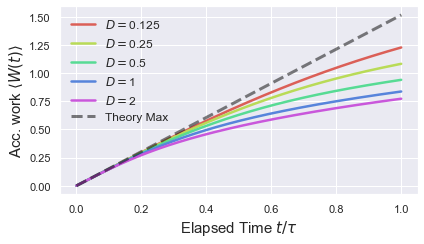

In [10]:
# And therefore, we can add this line to the previous plot
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)

# Theoretical max line
ax.plot([0, 1], [0, RE], '--', color='k', linewidth=3.0, alpha=0.5, label=r"Theory Max")

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)    
plt.tight_layout()

So, from this analysis, the theoretical maximum line looks to fall in line with the general trend of the accumualted work with decreasing diffusion coefficients. Next, we turn our focus to quantifying the final work as a function of diffusion coefficient. Here, the work is bound to be above zero, and below the inifinte-time result. In fact, we can also quantify a lower bound by noting that the work can generally be written as a sum over *excess* work and the change in equilibrium free energy

$$ \langle \beta W\rangle \equiv \langle \beta W_{\rm ex}\rangle + \beta \Delta F$$

and thus, in the limit of quasistatic evolution (where the diffusion coefficient $D\to\infty$) the excess work is zero and $\langle \beta W\rangle_{\rm quasi} = \beta\Delta F$. In general, we can evaluate the free energy through the expression (which follows from the definition of the Boltzmann distribution)

$$ \Delta F \equiv \ln\frac{Z_{\rm f}}{Z_{\rm i}}$$

for the partition function $Z$.  In this scenario, the partition function is

$$ Z = \int e^{-\frac{\beta k}{2}x^2} {\rm d} x = \sqrt{2\pi}{\beta k}$$

and thus the free energy difference between the initial and final equilibrium states is

$$ \beta\Delta F = \ln\frac{Z_{\rm f}}{Z_{\rm i}} = \frac{1}{2}\ln\frac{k_{\rm f}}{k_{\rm i}} $$

So, for $k_{\rm i} = 2$ adn $k_{\rm f} = 8$, the free energy difference between initial and final states is

$$\beta\Delta F = \frac{1}{2}\ln 4 \approx 0.693\dots $$

With this we can make one more version of the plot above, now with a lower bound on the work done at time $t$ (indicated by a black circle)


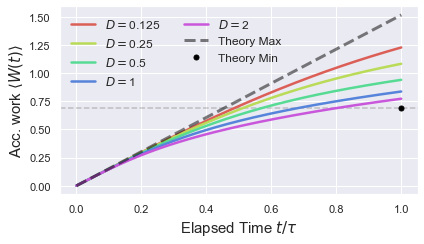

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.axhline(0.5 * np.log(4), linestyle='--', color='k', linewidth=1.5, alpha=0.2)
for i, diff in enumerate(D_arr):
    ax.plot(protocol_time, res_dict[f"D = {diff}"]["work"], color=Pal[i], label=r"$D = $" + str(diff), linewidth=2.5)

# Theoretical max line
ax.plot([0, 1], [0, RE], '--', color='k', linewidth=3.0, alpha=0.5, label=r"Theory Max")
# Theoretical min point
ax.plot([1], [0.5 * np.log(4)], 'o', markersize=5, color='k', label=r"Theory Min")


ax.legend(fontsize=12, frameon=False, ncol=2)
ax.set_xlabel(r"Elapsed Time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Acc. work $\langle W(t)\rangle$", fontsize=15)
plt.tight_layout()

In [12]:
# Now as a natural followup to this analysis, we can create a finer gradation
# of the diffusion coefficients, and propagate the dynamics to find what the
# functional relationship is between the total work at the end of the protocol,
# and the diffision coefficient
D_fine = np.linspace(0.05, 4, 100)
dk = protocol[1] - protocol[0]

# Now run the same protocol over each diffusion coefficient
final_work = []
for i, diff in enumerate(D_fine):
    if i % 10 == 0:
        print(f"D = {np.round(diff, 2)} ({i} of 100)")
    fpe = FPE_Integrator_1D(diff, dt, dx, x_array, boundaryCond='hard-wall', output=False)
    fpe.initializeProbability(0, 1 / k_init)
    fpe.initializePhysicalTrackers()
    for i, k in enumerate(protocol):
        fpe.work_step(([k, 0]), ([k + dk, 0]), ff.harmonicForce, ff.harmonicEnergy)
    final_work.append(fpe.workTracker[-1])

D = 0.05 (0 of 100)
D = 0.45 (10 of 100)
D = 0.85 (20 of 100)
D = 1.25 (30 of 100)
D = 1.65 (40 of 100)
D = 2.04 (50 of 100)
D = 2.44 (60 of 100)
D = 2.84 (70 of 100)
D = 3.24 (80 of 100)
D = 3.64 (90 of 100)


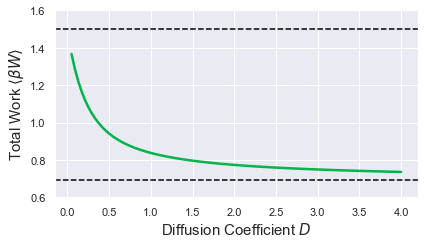

In [13]:
# And now we can look at the final work values
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

# Upper bound
ax.axhline(1.5, linestyle='--', linewidth=1.5, color='k')
# Lower bound
ax.axhline(0.5 * np.log(4), linestyle='--', linewidth=1.5, color='k')

ax.plot(D_fine, final_work, linewidth=2.5, color=sns.xkcd_rgb["shamrock"])
ax.set_ylim(0.6, 1.6)

ax.set_xlabel(r"Diffusion Coefficient $D$", fontsize=15)
ax.set_ylabel(r"Total Work $\langle\beta W\rangle$", fontsize=15)
plt.tight_layout()

Now, we can look at a related concept of *distance from equilibrium*. Intuitively, the reason why the slower diffusing systems require more work is that, through the course of the protocol they lag farther and farther behind the true equilibrium distribution of the system. Quantitatively, the distance from equilibrium can be quantified by the *nonequilibirum free energy* in the system, as defined in Ref[3].  Ultimately, this is the relative entropy between the current nonequilibrium distribution, and the corresponding equilibirum distribution at the current control parameter values. Conceptually, this term represents the additional free energy in the system (in principle, that could be used to perform useful work) above and beyond the equilibrium value.

So with the current data we have, we can calculate $D_{\rm KL}(p(x, t) || \pi(x, k(t)))$ at each point along the protocol, and see how this distance from equilibrium varies between diffusion coefficients.

In [16]:
def get_eq_dist(k_val: float, x_array: np.ndarray) -> np.ndarray:
    eq_dist = np.exp(-0.5 * k_val * (x_array ** 2))
    return eq_dist / np.sum(eq_dist * (x_array[1] - x_array[0]))

neq_fe_res = {}
for diff in D_arr:
    neq_fe_res[f"D = {diff}"] = {}
    results = res_dict[f"D = {diff}"]
    neq_fe = []
    for prob, k in zip(results["prob"], results["CP_val"]):
        eq_dist = get_eq_dist(k, x_array)
        neq_fe.append(get_rel_ent(prob, eq_dist, dx))
    neq_fe_res[f"D = {diff}"]["neq_free_energy"] = neq_fe
    neq_fe_res[f"D = {diff}"]["time"] = time_tracker


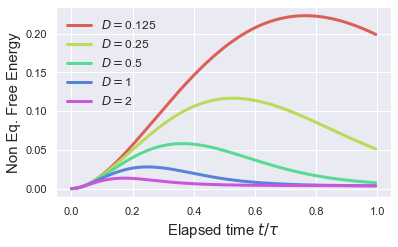

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", len(neq_fe_res))
for i, diff in enumerate(D_arr):
    ax.plot(neq_fe_res[f"D = {diff}"]["time"], neq_fe_res[f"D = {diff}"]["neq_free_energy"], color=Pal[i], linewidth=3.0, label=r"$D = $" + str(diff))

ax.set_xlabel(r"Elapsed time $t / \tau$", fontsize=15)
ax.set_ylabel(r"Non Eq. Free Energy", fontsize=15)
ax.legend(fontsize=12, frameon=False)


This is certainly a nontrivial result. Ultimately, the non-monotonic behaviour here arises from the dependence of the system relaxation time on the value of the spring constant (which, in this case, is the control parameter). So, after an initial trend of fallign further and further out of equilibrium, the system eventually starts to catch up, even for a constant velocity control protocol, and constant dynamics parameters

Now, we want to investigate another situation, inspired by results found by Sivak and Crooks in Ref[1]. Here, it is shown that, within the linear-response regime, the time-dependent control protocol that minimizes the excess work for a given (fixed) protocol duration $\tau$ proceeds with a control parameter velocity proportional to $k^3$. That is, when moving through a particular region of control-parameter space, then velocity with which $k$ is changing is proportioall to $k^3$.  Conceptually, this means that, contrary to the naive, constant velocity, control protocol we have looked at thus far, the optimal protocol instead moves much more rapidly in the regions of strong trap strengths, when compared to lower strengths.

Specifically, we know that an optimal protocol proceeds with a velocity  $\dot{\lambda} \propto 1 / \sqrt{\zeta(\lambda)}$. And, in this case, $\zeta(\lambda) \propto 1/ k^3$ so the optimal velocity profile for the protocol is $\dot{\lambda} \propto k^{3/2}$. 

To determine the optimal protocol $\lambda(t)$ we follows the construction of A. Kasper in her Masters Thesis, which starts with the so-called *raw* protocol velocities and times $\dot{\lambda}_{{\rm raw}, i}$ and $t_{{\rm raw}, i}$ for a set of discrete friction values. Here, while we have the friction for all control parameters, we want to solve for the optimal velocity values for a specific set of times, which means we face a similar issue.  So to do this, we first build a finely spaced grid of friction values at a set of control parameter values, and use that to calculate the *raw* time values (which are the times at which the system arrives at the $i$th control parameter value) as

$$ t_{{\rm raw}, i+1} = \frac{2(\lambda_{i+1} - \lambda_i)}{\dot{\lambda}_{{\rm raw}, i} + \dot{\lambda}_{{\rm raw}, i+1}} + t_{{\rm raw}, i}$$

Where the raw velocities are simple $\dot{\lambda}_{{\rm raw}, i} = \zeta^{-1/2}$. Then, we calculate the *true* times by scaling the raw times by the protocol duration $\tau$ as

$$ t_{i} = \frac{\tau}{t_{{\rm raw}, N}}t_{{\rm raw}, i}$$

In a similar manner, the true velocities are constructed from their *raw* versions as

$$ \dot{\lambda}_{i} = \frac{t_{{\rm raw}, N}}{\tau} \dot{\lambda}_{{\rm raw}, i}$$

Finally, we can calculate the control parameter value at any point in time by using the kinematic relationship (and assuming a constant acceleration between points of known velocity)

$$ \lambda(t) = \lambda_i + \dot{\lambda}_i(t - t_i) + \frac{(\dot{\lambda}_{i+1} - \dot{\lambda}_i)(t - t_i)^2}{2(t_{i+1} - t_i)} $$

Using this process, we can build the optimal (minimum-dissipation) control protocols at each of the intergartion step times and compare the work required (as compared to a naive, constant-velocity protocol)

In the following few cells, we develope a primitive `BreathingSimulator` class that implements this procedure, and avails the end-user to run either a naive (constant velocity) or optimal protocol for this breathing trap system.

In [69]:
# To accomplish this, we will structure out a primitive version of a Simulator class
# which will eventually serve as a basis for interfacing with the integrator itself
# and ultimately allow the end-user to easily onstruct models, and drive them in a
# variety of manners

import scipy.interpolate
import numpy as np
import copy

class BreathingSimulator: 

    def __init__(
        self, fpe: FPE_Integrator_1D, k_i: float, k_f: float, tau: float
    ):
        self.fpe = copy.deepcopy(fpe)
        self.k_i = k_i
        self.k_f = k_f
        self.dt = fpe.dt
        self.tau = tau
        self.time_array = np.arange(0, tau, self.dt)
        self.k_array = np.linspace(k_i, k_f, 500)
        self.raw_velocities = self._get_raw_velocity(self.k_array)

    def _get_raw_velocity(self, k: float):
        return (k ** (3/2))

    def _get_raw_times(self) -> np.ndarray:
        raw_times = np.zeros_like(self.k_array)
        for i in range(len(raw_times) - 1):
            numerator = 2 * (self.k_array[i+1] - self.k_array[i])
            denominator = (self.raw_velocities[i+1] + self.raw_velocities[i])
            raw_times[i+1] =  (numerator / denominator) + raw_times[i]

        return raw_times

    def _get_real_times(self, raw_times: np.ndarray) -> np.ndarray:
        raw_tau = raw_times[-1]
        self.real_times = (self.tau / raw_tau) * raw_times

    def _get_real_velocities(self, raw_times: np.ndarray) -> np.ndarray:
        raw_tau = raw_times[-1]
        self.real_velocities = (raw_tau / tau) * self.raw_velocities

    def build_optimal_protocol(self) -> np.ndarray:
        raw_times = self._get_raw_times()
        self._get_real_times(raw_times)
        self._get_real_velocities(raw_times)

        # Now, we can generate the pairs of (time, k_value) from the pairs of real_times, k_array
        # But we want a uniform set of times at which we know the k values, so we cna interpolate
        time_interp = scipy.interpolate.interp1d(self.real_times, self.k_array, fill_value="extrapolate")
        self.optimal_protocol = time_interp(self.time_array)
        return self.optimal_protocol

    def build_naive_protocol(self):
        self.naive_protocol = np.linspace(self.k_i, self.k_f, len(self.time_array))

    def run_simulation(self, mode: Optional[str] = "naive"):
        if mode == "naive":
            self.build_naive_protocol()
            protocol = self.naive_protocol
        elif mode == "optimal":
            self.build_optimal_protocol()
            protocol = self.optimal_protocol
        else:
            raise ValueError("`mode parameter must be `naive` or `optimal``")

        prob_tracker = []
        time_tracker = []
        cp_tracker = []

        fpe.initializeProbability(0, 1 / self.k_i)
        fpe.initializePhysicalTrackers()

        for i, k in enumerate(protocol[:-1]):
            if i % 10 == 0:
                prob_tracker.append(self.fpe.prob)
                time_tracker.append(self.time_array[i])
                cp_tracker.append(protocol[i])
            self.fpe.work_step(([protocol[i], 0]), ([protocol[i+1], 0]), ff.harmonicForce, ff.harmonicEnergy)

        return SimulationResult(self, cp_tracker, prob_tracker, time_tracker)


class SimulationResult:
    def __init__(
        self, fpe_obj: BreathingSimulator, cp_tracker: Iterable,
        prob_tracker: Iterable, time_tracker: Iterable
    ):
        self.fpe = fpe_obj
        self.prob_tracker = prob_tracker
        self.time_tracker = time_tracker
        self.cp_tracker = cp_tracker

    @property
    def work(self):
        return self.fpe.fpe.workTracker

    @property
    def time(self):
        return self.time_tracker

    @property
    def prob(self):
        return self.prob_tracker

    @property
    def cp(self):
        return self.cp_tracker


D = 1.0
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='hard-wall', output=False)

k_init = 2.0
k_final = 4.5
tau = 4.0

sim_naive = BreathingSimulator(fpe, k_init, k_final, tau)
sim_opt = BreathingSimulator(fpe, k_init, k_final, tau)

res_naive = sim_naive.run_simulation(mode="naive")
res_opt = sim_opt.run_simulation(mode="optimal")


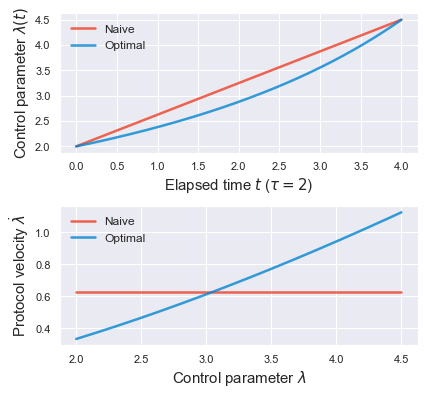

In [70]:
# Now, we can plot a comparison between the optimal and naive control protocols
# for this range of motion
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))
naive_velocity = ((k_final - k_init) / tau) * np.ones(2)

ax[0].plot(sim_naive.time_array, sim_naive.naive_protocol, label="Naive", color=sns.xkcd_rgb["tomato"], linewidth=2.5, alpha=0.8)
ax[0].plot(sim_opt.time_array, sim_opt.optimal_protocol, label="Optimal", color=sns.xkcd_rgb["cerulean"], linewidth=2.5, alpha=0.8)

ax[1].plot([k_init, k_final], naive_velocity, label="Naive", color=sns.xkcd_rgb["tomato"], linewidth=2.5, alpha=0.8)
ax[1].plot(sim_opt.k_array, sim_opt.real_velocities, label="Optimal", color=sns.xkcd_rgb["cerulean"], linewidth=2.5, alpha=0.8)

ax[0].set_xlabel(r"Elapsed time $t$ ($\tau = 2$)", fontsize=15)
ax[0].set_ylabel(r"Control parameter $\lambda(t)$", fontsize=15)

ax[1].set_xlabel(r"Control parameter $\lambda$", fontsize=15)
ax[1].set_ylabel(r"Protocol velocity $\dot{\lambda}$", fontsize=15)

ax[0].legend(fontsize=12, frameon=False)
ax[1].legend(fontsize=12, frameon=False)
plt.tight_layout()

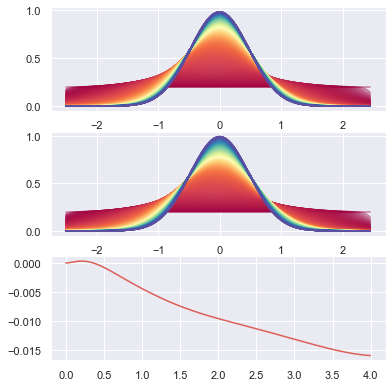

In [71]:
# And now a plot of the distributions over time
fig, ax = plt.subplots(3, 1, figsize=(6, 6.5))
rel_ent_tracker = []
Pal = sns.color_palette("Spectral", len(res_naive.prob_tracker))
for i, (prob_naive, prob_opt) in enumerate(zip(res_naive.prob_tracker, res_opt.prob_tracker)):
    ax[0].plot(fpe.xArray, prob_naive, color=Pal[i], alpha=0.5)
    ax[1].plot(fpe.xArray, prob_opt, color=Pal[i], alpha=0.5)
    rel_ent_tracker.append(get_rel_ent(prob_naive, prob_opt, fpe.dx))
ax[2].plot(res_naive.time_tracker, rel_ent_tracker)

In [63]:
# And finally, the accumulated work
